# Bin 파일 읽어드리는 법

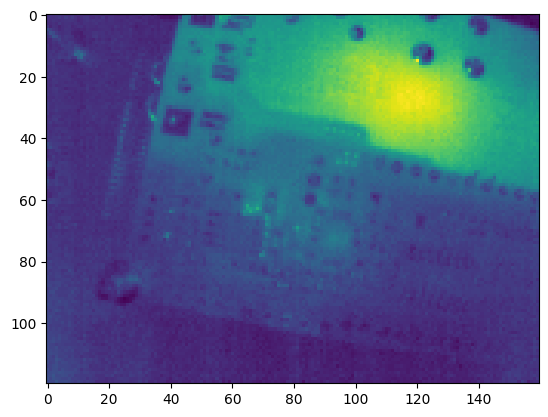

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
from glob import glob

# .npy 파일을 NumPy 배열로 읽기
arr = np.load('3.개방데이터/1.데이터/1.Training/1.원천데이터/agv/01/agv01_0901_0812/agv01_0901_081240.bin')

# 결과 출력
plt.figure()
plt.imshow(arr)
plt.show()


# 

# 데이터 전처리 필요
## 판다스로 DataFrame으로 규격화

### 라벨링 데이터 통합

In [5]:
import json

# 우선 agv/01/agv01_0901_0812에 있는 원천 데이터와 라벨링 데이터만 전처리
# 데이터 폴더는 3.개방데이터/1.데이터/1.Training...이런식으로 이루어지면됩니다.
# 원천 데이터
root_raw_path = '3.개방데이터\\1.데이터\\1.Training\\1.원천데이터\\agv' # oht로 하고 싶으면 agv대신 oht를 넣으면된다.
root_label_path = '3.개방데이터\\1.데이터\\1.Training\\2.라벨링데이터\\agv'
numbers_path_list = os.listdir(root_raw_path) # 01 폴더, 02 폴더, ... 16폴더
recursive_path_list = os.listdir(os.path.join(root_raw_path,numbers_path_list[0])) # agv01_0901_0812, agv01_0902_1253,...,agv01_1027_1405
# return된 중요한 변수는 bin_files,features_files, label_json_files 과 같은 원천데이터와 라벨링 데이터

def sort_and_list(root_raw_path:str,root_label_path:str,number:str,recursive_path:str) -> tuple:
    """멀티 모달의 데이터의 파일 경로들을 전처리하는 함수입니다.
       (bin_files:List, features_files:List,label_json_files:List)와 같이 반환됩니다.
       각각의 bin_file은 bin파일이 담긴 리스트, features_files는 원천 데이터의 온도,전류,미세먼지 센서데이터가 있는 파일 리스트, label_json_files는 라벨링 데이터가 담긴 json파일들이 존재합니다.
    """
    target_path = os.path.join(root_raw_path,number,recursive_path)
    bin_files = glob(target_path + '\*.bin') # 원천 데이터의 bin파일
    features_files = glob(target_path + '\*.csv') # 원천 데이터의 csv파일
    
    target_label_path = os.path.join(root_label_path,number,recursive_path)
    label_json_files = glob(target_label_path+'\*.json')
    return bin_files,features_files,label_json_files

def transition_json_to_dataframe(label_json_files:list):
    """json파일의 라벨링 데이터가 담긴 리스트로 부터 각각의 json파일로부터 필요한 외부 데이터(외부온도, 외부습도, 조도)와 정답 데이터(state) 파싱"""
    dataframe = pd.DataFrame()
    for i in label_json_files:
        with open(i,'r',encoding='utf-8') as file:
            data = json.load(file)
            state = data['annotations'][0]['tagging'][0]['state'] # 기기 상태 0이면 정상 1이면 비정상
            ex_temperature = data['external_data'][0]['ex_temperature'][0]['value']
            ex_humidity = data['external_data'][0]['ex_humidity'][0]['value']
            ex_illuminance = data['external_data'][0]['ex_illuminance'][0]['value']
            device_id = data['meta_info'][0]['device_id']
            collection_date = data['meta_info'][0]['collection_date']
            collection_time = data['meta_info'][0]['collection_time']
            cumulative_operating_day = data['meta_info'][0]['cumulative_operating_day']
            temp = pd.DataFrame({'device_id':[device_id],'collection_date': [collection_date], 'collection_time':[collection_time], 
                                 'cumulative_operating_day':[cumulative_operating_day],'ex_temperature':[ex_temperature],'ex_humidity':[ex_humidity],
                                 'ex_illuminance':[ex_illuminance],'state':[state]})
            dataframe = pd.concat([dataframe,temp],ignore_index=True)
    return dataframe

def transition_feature_to_dataframe(features_files:list):
    """NTC, PM.1.0 과 같이 피쳐가 담긴 csv파일 List를 DataFrame으로 정리하는 함수"""
    dataframe = pd.DataFrame()
    for i in features_files:
        temp = pd.read_csv(i)
        dataframe = pd.concat([dataframe,temp],ignore_index=True)
    dataframe = pd.concat([pd.DataFrame({'filenames':features_files}),dataframe],axis=1)
    dataframe['filenames']=dataframe['filenames'].apply(lambda x: x.rsplit('.', 1)[0] + '.bin')
    return dataframe

def make_final_dataframe(label_dataframe,feature_dataframe):
    return pd.concat([feature_dataframe,label_dataframe],axis=1)

### feature_files 데이터셋 통합

agv01_0901_0812 데이터셋

# 01 ~ 16 폴더의 모든 압축해제

In [70]:
import zipfile
root_raw_path = '3.개방데이터\\1.데이터\\1.Training\\1.원천데이터\\oht' # oht 압축해제하고싶다면 oht로로
root_label_path = '3.개방데이터\\1.데이터\\1.Training\\2.라벨링데이터\\oht'

def extract_zipfile(zipfilepath,destination_path):
    """압축해체"""
    with zipfile.ZipFile(zipfilepath,'r') as zip_ref:
        zip_ref.extractall(destination_path)
    print(f'{destination_path} 디렉토리에 성공적으로 해제')

# 원천데이터 압축해제
for name in numbers_path_list:
    extract_zipfile(os.path.join(root_raw_path,name) + '.zip', os.path.join(root_raw_path,name.split('.')[0]))
# 라벨링 데이터 압축해제
for name in numbers_path_list:
    extract_zipfile(os.path.join(root_label_path,name) + '.zip', os.path.join(root_label_path,name.split('.')[0]))


## 해야할 것 01 ~ 16 폴더의 모든 순번폴더를 순회하면서 순번폴더안에있는 각 종 폴더내의 bin폴더와 csv를 모두 읽어오고 라벨링 폴더 내부의 json도 같이 가져와야함

In [10]:
dataframe = pd.DataFrame()
root_raw_path = '3.개방데이터\\1.데이터\\2.Validation\\1.원천데이터\\agv' # oht 압축해제하고싶다면 oht로
root_label_path = '3.개방데이터\\1.데이터\\2.Validation\\2.라벨링데이터\\agv'
numbers_path_list = os.listdir(root_raw_path) # 01 폴더, 02 폴더, ... 16폴더
recursive_path_list = os.listdir(os.path.join(root_raw_path,numbers_path_list[0])) # agv01_0901_0812, agv01_0902_1253,...,agv01_1027_1405
for idx,name in enumerate(numbers_path_list):
    recursive_path_list = os.listdir(os.path.join(root_raw_path,numbers_path_list[idx]))
    for folder in recursive_path_list:
        bin_files,features_files,label_json_files = sort_and_list(root_raw_path,root_label_path,name,folder) 
        label_dataframe = transition_json_to_dataframe(label_json_files)
        feature_dataframe = transition_feature_to_dataframe(features_files)
        final_dataframe = make_final_dataframe(label_dataframe,feature_dataframe)
        dataframe = pd.concat([dataframe,final_dataframe],axis=0,ignore_index=True)
dataframe

,filenames,NTC,PM1.0,PM2.5,PM10,CT1,CT2,CT3,CT4,device_id,collection_date,collection_time,cumulative_operating_day,ex_temperature,ex_humidity,ex_illuminance,state
0,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,18.0,22.0,42.0,1.82,74.97,49.92,19.96,agv17,09-02,19:08:41,13,25.0,30.0,157.0,0
1,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,19.0,22.0,41.0,1.86,74.88,49.92,19.95,agv17,09-02,19:08:42,13,26.0,29.0,160.0,0
2,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.80,18.0,21.0,40.0,1.82,74.95,49.97,19.95,agv17,09-02,19:08:43,13,26.0,30.0,156.0,0
3,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.71,18.0,21.0,40.0,1.89,75.01,49.91,20.00,agv17,09-02,19:08:44,13,26.0,27.0,159.0,0
4,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\17\agv1...,22.70,16.0,22.0,40.0,2.03,74.86,49.99,20.02,agv17,09-02,19:08:45,13,26.0,27.0,158.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4686,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,56.24,40.0,48.0,83.0,1.77,242.24,49.75,187.04,agv18,10-27,14:22:02,13,26.0,31.0,153.0,3
4687,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,56.20,41.0,48.0,83.0,2.05,246.04,49.76,191.15,agv18,10-27,14:22:03,13,25.0,34.0,155.0,3
4688,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,55.97,41.0,48.0,83.0,1.96,250.22,49.87,195.20,agv18,10-27,14:22:04,13,25.0,34.0,156.0,3
4689,3.개방데이터\1.데이터\2.Validation\1.원천데이터\agv\18\agv1...,55.90,42.0,48.0,83.0,1.84,254.90,49.72,199.78,agv18,10-27,14:22:05,13,25.0,28.0,152.0,3


In [9]:
import joblib
joblib.dump(dataframe,'agv_test_17_18.pkl')

['agv_test_17_18.pkl']